In [83]:
import pickle
import numpy as np
import pandas as pd
from math import floor, ceil
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
CATS = ['rsivl', 'sav_obj_sce', 'ic9600_sce', 'sav_art', 'sav_sup', 'ic9600_paint', 'visc', 'sav_int']

In [33]:
data = pickle.load(open("/ptmp/tshen/shared/Results/results.p", "rb"))

# 2D Histograms of Complexity ~ Num_seg, Num_class

In [181]:
def create_heatmap(x, y, z, title, figsize, num_bins, xlabel, ylabel, quantity="mean",
                   height_scale=None, cmap='BuGn', cbar_ratio=0.6, cbar_title=None, dpi=100, outpath=None):
    # Create 2D histogram
    _, xedges, yedges = np.histogram2d(x, y, bins=num_bins)  # get bin boundaries

    # Bin the third vector and compute average value for each bin
    # bin_means = np.zeros((num_bins, num_bins))
    bin_arrays = [[[] for _ in range(num_bins)] for _ in range(num_bins)]
    bin_counts = np.zeros((num_bins, num_bins))

    for i in range(len(z)):
        x_bin = np.searchsorted(xedges, x[i]) - 1
        y_bin = np.searchsorted(yedges, y[i]) - 1
        # bin_means[x_bin, y_bin] += z[i]
        bin_arrays[x_bin][y_bin].append(z[i])
        bin_counts[x_bin, y_bin] += 1

    if "mean" in quantity:
        print("Showing heatmap of mean values")
        bin_quant = np.array([[np.mean(a) if len(a) > 0 else np.nan for a in aa] for aa in bin_arrays])

        if "complexity" in quantity:
            vmin, vmax = 0, 100
        else:
            vmin, vmax = floor(np.nanmin(bin_quant)), ceil(np.nanmax(bin_quant))
    else:
        print("Showing heatmap of std values")
        bin_quant = np.array([[np.std(a) if len(a) > 0 else np.nan for a in aa] for aa in bin_arrays])
        vmin, vmax = floor(np.nanmin(bin_quant)), ceil(np.nanmax(bin_quant))

    # bin_means = bin_means / np.where(bin_counts > 0, bin_counts, np.nan)  # Avoid division by zero

    fig, ax = plt.subplots(figsize=figsize)

    if height_scale is None:
        w, h = figsize
        height_scale = h*(xedges[-1]-xedges[0]) / (w * (yedges[-1]-yedges[0]))

    # Plot the heatmap
    cmap = mpl.colormaps.get_cmap(cmap)
    cmap.set_bad(color='#dddddd')

    im = ax.imshow(bin_quant.T, cmap=cmap, origin='lower', 
              vmin=vmin, vmax=vmax, aspect=height_scale, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

    if "twosided" in quantity:
        max_abs_value = np.nanmax(np.abs(bin_quant))
        sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=-max_abs_value, vmax=max_abs_value))
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax, label=cbar_title, shrink=cbar_ratio, pad=0.02)
    else:
        cbar = plt.colorbar(im, label=cbar_title, shrink=cbar_ratio, pad=0.02)
    
    ax.set_xticks(xedges, labels=[round(x, 1) for x in xedges])
    ax.set_yticks(yedges, labels=[round(y, 1) for y in yedges])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if outpath is not None:
        fig.savefig(outpath, dpi=dpi, bbox_inches='tight', transparent=True)
        plt.close()

    return fig, xedges, yedges, bin_quant, bin_counts

In [168]:
def plot_hist(x, xedges, alpha=0.5, ticklabelsize=24,
              color='#DDB967', invert=False, figsize=(12, 4), dpi=100, outpath=None):

    fig, ax = plt.subplots(figsize=figsize)

    _, _, _ = ax.hist(x, bins=xedges, alpha=alpha, color=color, density=False,
            align="mid", weights=np.ones(len(x)) / len(x))

    if invert:
        ax.invert_yaxis()
        ax.tick_params(axis="x", which="both", top=True, bottom=False)
        
    ax.set_xticks([round(x, 2) for x in xedges])
    ax.set_xticklabels([])
    ax.tick_params(axis="y", labelsize=ticklabelsize)
    ax.set_xlim(round(xedges[0], 2), round(xedges[-1], 2))
    # floor(np.nanmin(bin_quant)), ceil(np.nanmax(bin_quant))

    if outpath is not None:
        fig.savefig(outpath, dpi=dpi, bbox_inches='tight', transparent=True)
        plt.close()

    return fig

In [7]:
def combine_plots(paths=[], positions=[], sizes=[], rotations=[], imagesize=(800, 600), show_border=False):

    canvas = Image.new('RGB', imagesize, 'white')
    if show_border:
        border_size = 1
        border_color = (0, 0, 0)  # black
        canvas = ImageOps.expand(canvas, border=(border_size, border_size, border_size, border_size), fill=border_color)

    for path, pos, size, rot in zip(paths, positions, sizes, rotations):
        # positions as fractional coordinates of imagesize
        # sizes as fractional sizes of imagesize first dimension
        x_pos, y_pos = int(pos[0]*imagesize[0]), int(pos[1]*imagesize[1])
        max_size = int(size*max(imagesize))
        
        img = Image.open(path)
        img = img.rotate(rot, expand=True)
        img.thumbnail((max_size, max_size))
        
        _,_,_, mask = img.convert('RGBA').split()
        
        canvas.paste(img, (x_pos, y_pos), mask)

    display(canvas)
    # canvas.save('path/to/final_image.jpg')

In [200]:
def plot_2d_hist(dset, xname, yname, zname, quantity, xlabel, ylabel, cmap='Greens', title="title", num_bins=5, working_folder="./out/"):
    df = data[dset]
    df = df[~(df[xname].isna() | df[yname].isna())]
    df = df.reset_index()

    x = df[xname]
    y = df[yname]
    z = df[zname]

    _, xedges, yedges, _, _ = create_heatmap(x=x, y=y, z=z, quantity=quantity, title=title, xlabel=xlabel, ylabel=ylabel,
                                             cmap=cmap, figsize=(10, 4), num_bins=num_bins, outpath= working_folder + "temp.png")

    fig = plot_hist(x, xedges, invert=True, ticklabelsize=16, figsize=(12, 2), outpath=working_folder + "temp1.png")
    fig = plot_hist(y, yedges, ticklabelsize=20, figsize=(6, 2), outpath=working_folder + "temp2.png")

    combine_plots(
        paths=[
            working_folder + "temp.png",
            working_folder + "temp1.png",
            working_folder + "temp2.png",
        ],
        positions=[
            (0.15, 0.0),
            (0.185, 0.65), 
            (0.05, 0.055),    
        ],
        sizes=[0.99, 0.66, 0.3],
        rotations=[0, 0, 90],
        imagesize=(1000, 500), show_border=False)

In [212]:
def plot_2d_hist_joined(dset, xname, yname, zname, xlabel, ylabel, twosided="", cmap=['Greens', 'Greens'], title="title", num_bins=5, working_folder="./out/"):
    print("Dataset: {}".format(dset))
    df = data[dset]
    df = df[~(df[xname].isna() | df[yname].isna())]
    df = df.reset_index()

    x = df[xname]
    y = df[yname]
    z = df[zname]

    _, xedges, yedges, _, _ = create_heatmap(x=x, y=y, z=z, quantity="mean {}".format(twosided), title="{} Mean".format(title), xlabel=xlabel, ylabel=ylabel,
                                             cmap=cmap[0], figsize=(8, 4), num_bins=num_bins, outpath= working_folder + "temp.png")

    _, xedges, yedges, _, _ = create_heatmap(x=x, y=y, z=z, quantity="std", title="{} Std".format(title), xlabel=xlabel, ylabel=ylabel,
                                             cmap=cmap[1], figsize=(4, 4), num_bins=num_bins, outpath= working_folder + "temp3.png")

    fig = plot_hist(x, xedges, invert=True, ticklabelsize=24, figsize=(16, 2), outpath=working_folder + "temp1.png")
    fig = plot_hist(y, yedges, ticklabelsize=18, figsize=(6, 2), outpath=working_folder + "temp2.png")

    combine_plots(
        paths=[
            working_folder + "temp.png",
            working_folder + "temp1.png",
            working_folder + "temp2.png",
            working_folder + "temp3.png",
        ],
        positions=[
            (0.1, 0.0),
            (0.145, 0.77), 
            (0.02, 0.07),    
            (0.67, 0.0),    
        ],
        sizes=[0.9, 0.47, 0.25, 0.9],
        rotations=[0, 0, 90, 0],
        imagesize=(1150, 450), show_border=False)

## Explaining Our Model

Dataset: rsivl
Showing heatmap of mean values
Showing heatmap of std values


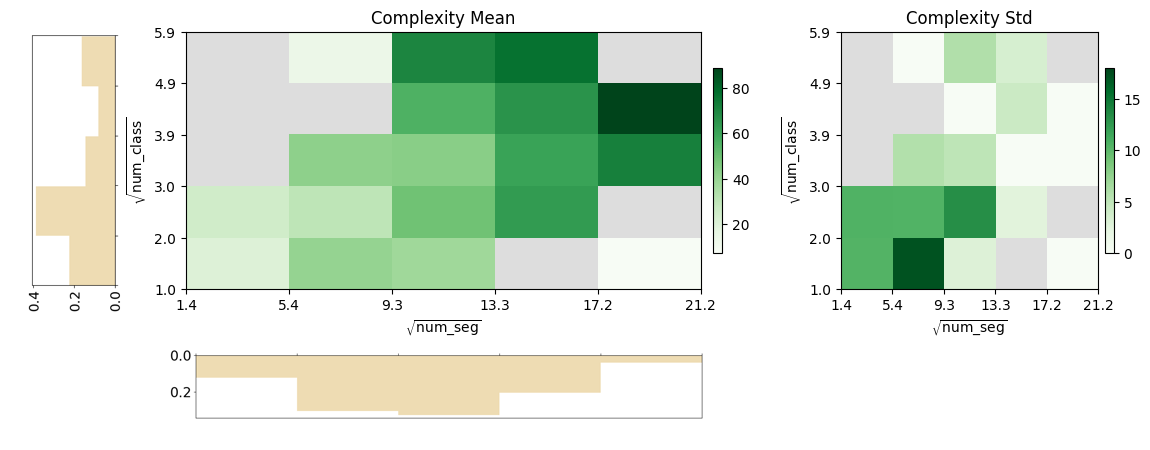

Dataset: sav_obj_sce
Showing heatmap of mean values
Showing heatmap of std values


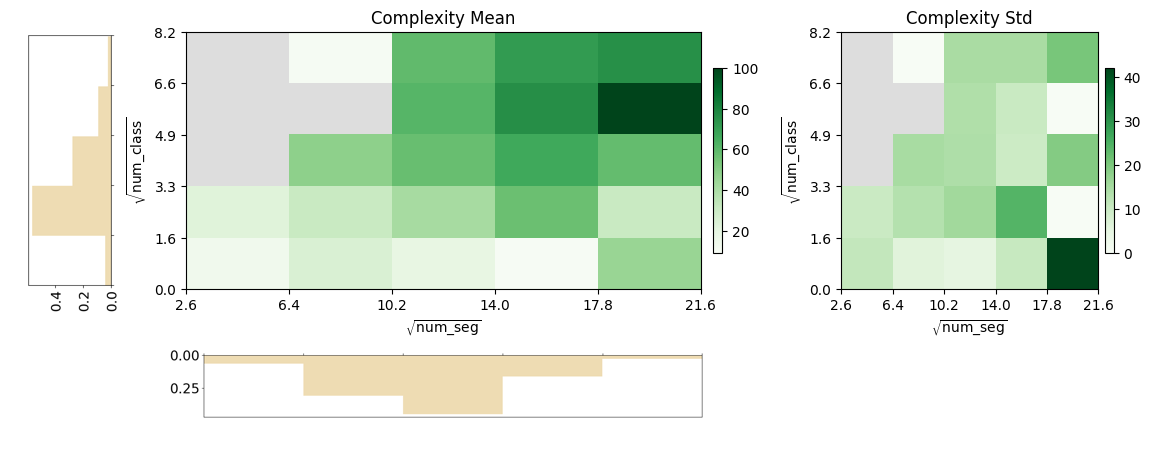

Dataset: ic9600_sce
Showing heatmap of mean values
Showing heatmap of std values


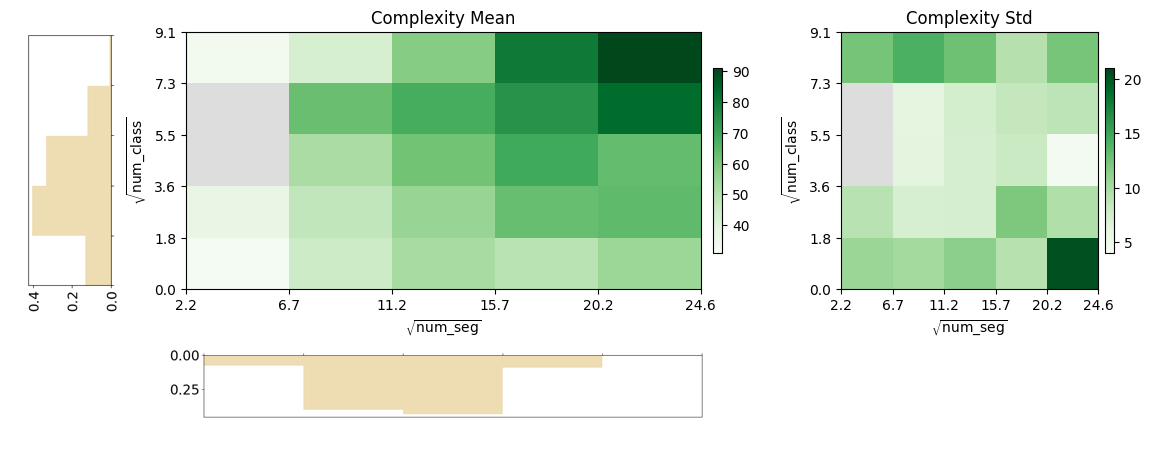

Dataset: sav_art
Showing heatmap of mean values
Showing heatmap of std values


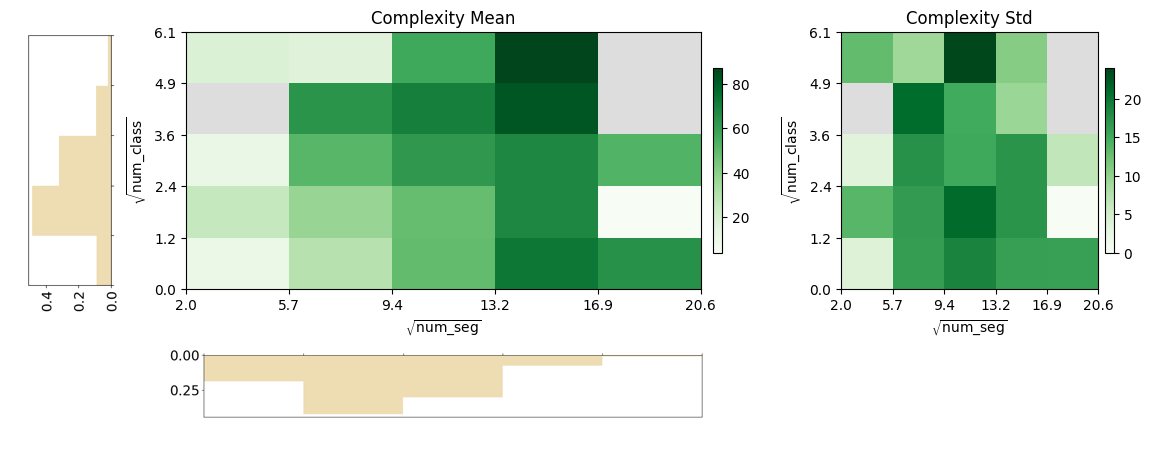

Dataset: sav_sup
Showing heatmap of mean values
Showing heatmap of std values


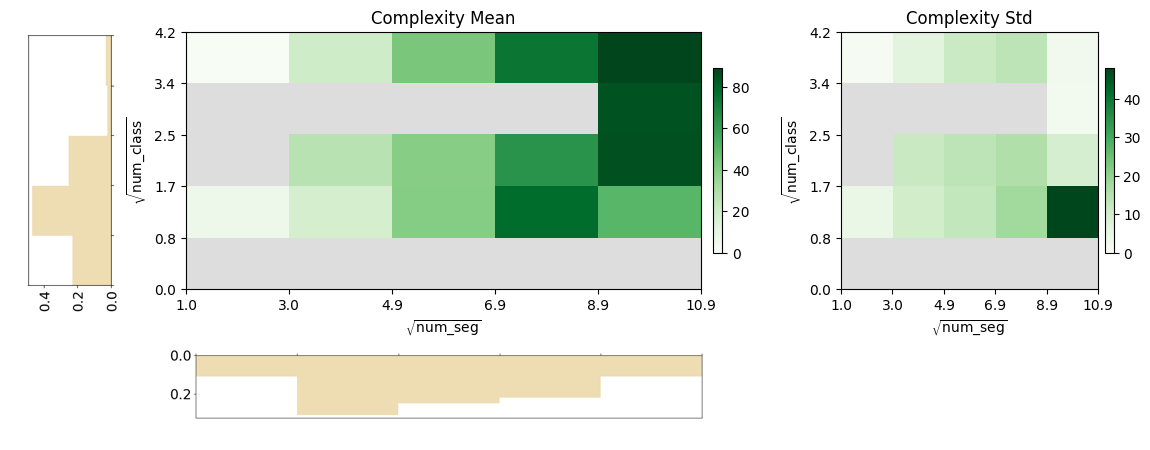

Dataset: ic9600_paint
Showing heatmap of mean values
Showing heatmap of std values


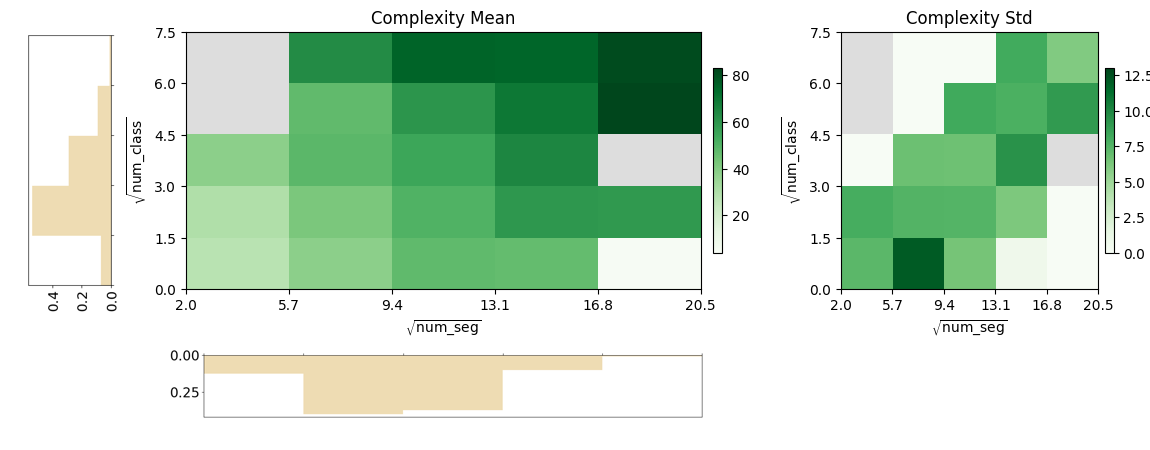

Dataset: visc
Showing heatmap of mean values
Showing heatmap of std values


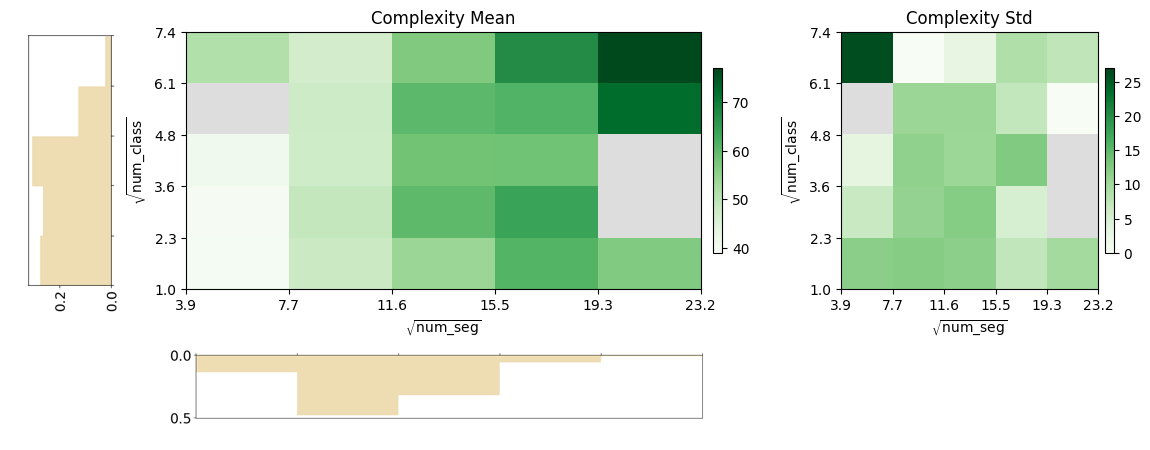

Dataset: sav_int
Showing heatmap of mean values
Showing heatmap of std values


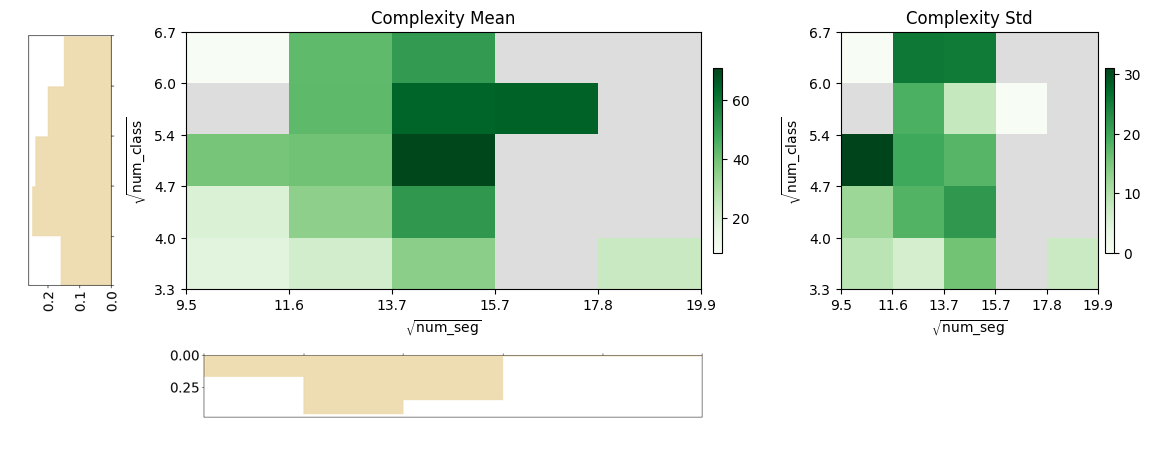

In [207]:
xlabel = r"$\sqrt{\mathrm{num\_seg}}$"
ylabel = r"$\sqrt{\mathrm{num\_class}}$"

for c in CATS:
    plot_2d_hist_joined(c, "sqrt_seg_64points", "sqrt_num_classes", "complexity", xlabel, ylabel, title="Complexity".format(c))